In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

In [2]:
def SW_gradSW(u,v,Teta):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    
    nbProj = Teta.shape[0]
    
    SW = 0
    gradSW = np.zeros((N,M,d))
    
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        
        for j in range(N*M):
                gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    SW = SW/nbProj
    
    return SW, gradSW

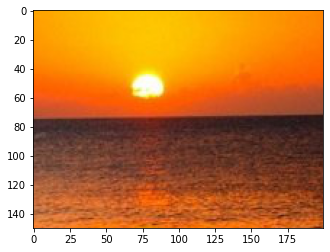

In [3]:
I1 = plt.imread('../data/coucher.jpg')
Xtrue = I1[100:250, 450:650, :]/255
plt.imshow(Xtrue)

In [4]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out  
    
    
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

In [5]:
def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

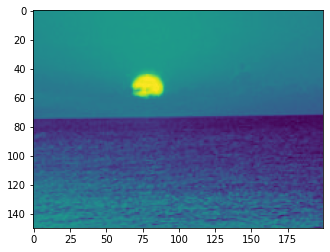

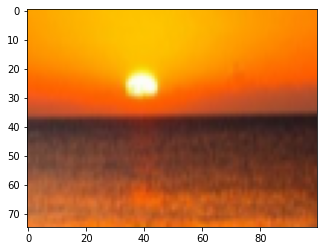

In [6]:
L_M = spectrale_degradation(Xtrue, 1, 3, 0)
L_H = spatial_degradation(Xtrue, 2, 0)
plt.figure()
plt.imshow(L_M)
plt.figure()
plt.imshow(L_H)

In [157]:
def normalize(im):
    imNorm = np.zeros((im.shape))
    for i in range(im.shape[2]):
        if np.sum(im[:,:,i]) != 0:
            imNorm[:,:,i] = im[:,:,i]/np.sum(im[:,:,i])
        else:
            imNorm[:,:,i] = im[:,:,i]
    return imNorm

def normalize2(im):
    imNorm = np.zeros((im.shape))
    if np.sum(im) != 0:
        imNorm = im/np.sum(im)
    else:
        imNorm = im
    return imNorm


def renorm(im):
    imRenorm = np.zeros((im.shape))
    for i in range(im.shape[2]):
        if(im[:,:,i].max()==0):
            imRenorm[:,:,i] = im[:,:,i]
        else:
            imRenorm[:,:,i] = im[:,:,i]*(1/im[:,:,i].max())
    return imRenorm

def renorm2(im):
    imRenorm = np.zeros((im.shape))
    if(im.max()==0):
        imRenorm = im
    else:
        imRenorm = im*(1/im.max())
    return imRenorm

In [149]:
L_H_n = normalize2(L_H)
L_M_n = normalize2(L_M)
X = reech_interp(L_H_n, 2)
Xpasnorm = reech_interp(L_H, 2)
d_H = L_H.shape[2]
random_state = np.random.RandomState(None)
Teta_H = random_state.normal(0., 1., [50, d_H])
norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
Teta_H = Teta_H / norm_H

d_M = L_M.shape[2]
random_state = np.random.RandomState(None)
Teta_M = random_state.normal(0., 1., [50, d_M])
norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
Teta_M = Teta_M / norm_M

In [150]:
sw, gradsw = SW_gradSW(spatial_degradation(X, 2, 0), L_H_n, Teta_H)

In [151]:
sw

8.430768215968051e-10

In [152]:
gradsw = spatial_degradation(gradsw, 2, 1)
gradsw

array([[[-2.69287258e-07, -2.47943066e-07,  1.48715274e-07],
        [-2.68870468e-07, -2.47760939e-07,  1.48823850e-07],
        [-2.64394092e-07, -2.17010528e-07,  1.49711484e-07],
        ...,
        [-5.97351776e-07, -5.64048271e-07,  6.96506390e-10],
        [-6.06858936e-07, -5.65580021e-07, -8.35390150e-09],
        [-6.07041009e-07, -5.64918880e-07, -8.49742340e-09]],

       [[-2.69287258e-07, -2.47943066e-07,  1.48715274e-07],
        [-2.68870468e-07, -2.47760939e-07,  1.48823850e-07],
        [-2.64394092e-07, -2.17010528e-07,  1.49711484e-07],
        ...,
        [-5.97351776e-07, -5.64048271e-07,  6.96506390e-10],
        [-6.06858936e-07, -5.65580021e-07, -8.35390150e-09],
        [-6.07041009e-07, -5.64918880e-07, -8.49742340e-09]],

       [[-2.89094198e-07, -1.70525817e-07,  1.21469855e-07],
        [-2.88521627e-07, -1.70063344e-07,  1.22226000e-07],
        [-2.76222383e-07, -1.76556173e-07,  1.37409150e-07],
        ...,
        [-5.83970863e-07, -5.32622114e-07,

In [7]:
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def PSNR(reference, reconstruct):
    mse = np.mean((reference - reconstruct) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def aSAM(reference, reconstruct):
    N = reference.shape[0]
    M = reference.shape[1]
    asam = 0
    for j in range(N*M):
        ps = np.dot(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)].transpose())
        norm = np.linalg.norm(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])*np.linalg.norm(reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])
        asam = asam + np.arccos(ps/norm)
    asam = asam/(N*M)
    return asam

def acSSIM(reference, reconstruct):
    l = reference.shape[2]
    acssim = 0
    for i in range(l):
        acssim = acssim + skimage.metrics.structural_similarity(reference[:,:,i], reconstruct[:,:,i])
    acssim = 1 - acssim/l
    return acssim    

In [185]:
def Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, Teta_M)

    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    
    Gradient_quad = 2*(X-reech_interp(L_H, K_ech))
    Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
    Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad
    
    Fct = Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2
    
    return Fct, grad, Lbd_SW1*SW1, Lbd_SW2*SW2, mu*L2

def Fct_gradFct2(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(normalize2(X), K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(normalize2(X), b_low, b_high, 0), L_M, Teta_M)

    L2 = np.linalg.norm(normalize2(X)-reech_interp(L_H, K_ech))**2
    
    Gradient_quad = 2*(normalize2(X)-reech_interp(L_H, K_ech))
    Gradient1 = spatial_degradation(renorm2(Gradient1), K_ech, 1)
    Gradient2 = spectrale_degradation(renorm2(Gradient2), b_low, b_high, 1)
    Gradient_quad = renorm2(Gradient_quad)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad
    
    Fct = Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2
    
    return Fct, grad, Lbd_SW1*SW1, Lbd_SW2*SW2, mu*L2


In [186]:
def RechercheLineaire(out, fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    i = 0
    alpha_l = 0
    alpha_r = 1
    
    sigma = 10**-3
    teta = 0.2
    
    pas = 0.5
    
    g = np.linalg.norm(grad)
    
    fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    norme_descendu = np.linalg.norm(grad_descendu)
    while(fct-fct_descendu < sigma*pas*g**2) or (g*norme_descendu < sigma*pas*g**2):
        if(fct-fct_descendu < sigma*pas*g**2):#Pas trop long
            alpha_r = pas
            pas = (alpha_l+alpha_r)/2
        else:
            if(g*norme_descendu < sigma*pas*g**2):
                alpha_l = pas
                pas = (alpha_l+alpha_r)/2
        i = i+1
        fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
        norme_descendu = np.linalg.norm(grad_descendu)
        if(pas <= 0.000001):
            return 0
    return pas
               

In [187]:
def gradientDescente_pasConstant(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    X = X - pas*grad

    
    nu = 10**-8
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2

def gradientDescente_pasConstant2(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = renorm2(reech_interp(L_H, K_ech))
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct2(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    X = X - pas*grad

    
    nu = 10**-8
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct2(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct2(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2


def gradientDescente_pasRL(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    X = X - pas*grad

    
    nu = 10**-10
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2

In [188]:
L_H_norm = normalize2(L_H)
L_M_norm = normalize2(L_M)

In [190]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H_norm, L_M_norm, 2, 1, 3, 100, 1, 0.1, 10, 0.01)

iter =  1 pas =  0.01 fonction =  3.928484220632119e-06
iter =  2 pas =  0.01 fonction =  3.9121657090114235e-06
iter =  3 pas =  0.01 fonction =  3.907710652032215e-06
iter =  4 pas =  0.01 fonction =  3.905710230197296e-06
iter =  5 pas =  0.01 fonction =  3.904649931571372e-06
iter =  6 pas =  0.01 fonction =  3.903949089059665e-06
iter =  7 pas =  0.01 fonction =  3.903459440952613e-06


In [191]:
X_renorm = renorm2(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


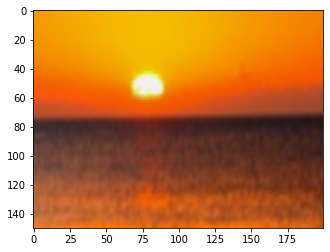

In [192]:
plt.imshow(X_renorm)

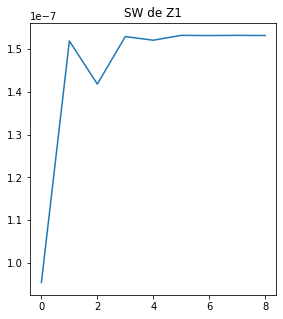

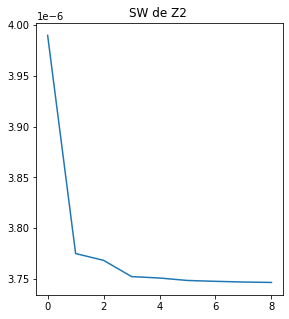

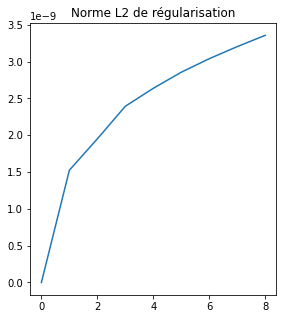

In [193]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [194]:
print("erreur PSNR : ", PSNR(Xtrue, X_renorm))
print("erreur SAM : ", aSAM(Xtrue, X_renorm))
print("erreur aSSIM : ", acSSIM(Xtrue, X_renorm))
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp(L_H, 2)))

erreur PSNR :  77.59756311178182
erreur SAM :  0.022679561338093273
erreur aSSIM :  0.10529415851850832
PSNR de X barre :  79.45053730674816


In [168]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H_norm, L_M_norm, 2, 1, 3, 1000, 1, 0.1, 10)

iter =  1 pas =  0.0009765625 fonction =  4.796593947075299e-06
iter =  2 pas =  0.00390625 fonction =  4.153892296867146e-06
iter =  3 pas =  0.001953125 fonction =  4.149210655187763e-06
iter =  4 pas =  0.0009765625 fonction =  4.146497690684065e-06
iter =  5 pas =  0.00390625 fonction =  4.099896258052099e-06
iter =  6 pas =  0.001953125 fonction =  4.097288803442617e-06
iter =  7 pas =  0.0009765625 fonction =  4.096506853590749e-06
iter =  8 pas =  0.001953125 fonction =  4.08809126163595e-06
iter =  9 pas =  0.000244140625 fonction =  4.0877498762731765e-06


In [169]:
X_renorm = renorm2(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


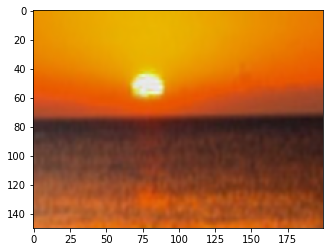

In [170]:
plt.imshow(X_renorm)

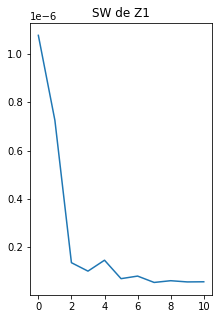

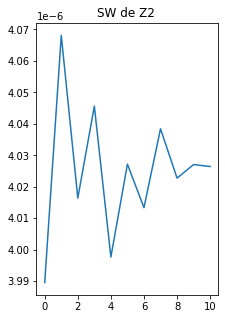

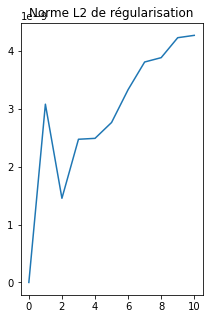

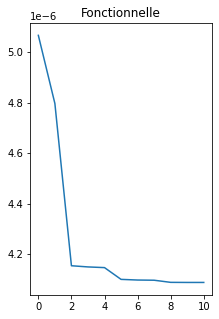

In [171]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,4,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,4,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.figure(figsize=(15,5))
plt.subplot(1,4,4)
plt.plot(Fct)
plt.title("Fonctionnelle")

plt.show()

In [172]:
print("erreur PSNR : ", PSNR(Xtrue, X_renorm))
print("erreur SAM : ", aSAM(Xtrue, X_renorm))
print("erreur aSSIM : ", acSSIM(Xtrue, X_renorm))
print("PSNR de X barre : ", PSNR(Xtrue, renorm(reech_interp(L_H_n, 2))))

erreur PSNR :  74.2544569330214
erreur SAM :  0.021796924707701226
erreur aSSIM :  0.10371338516687567
PSNR de X barre :  79.37361962233068
